In [0]:
import keras
import cv2
import numpy as np
import pandas as pd
import tensorflow as tf
from itertools import count
from sklearn.metrics import accuracy_score
from keras.datasets import mnist
from keras.applications.vgg16 import VGG16
from keras.layers import Dense, Dropout, Flatten, Activation, Input, Conv2D, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D
from keras.models import Model
from keras.callbacks import EarlyStopping
from scipy.stats import pearsonr
from tqdm import tqdm

In [0]:
BATCH_SIZE = 128
EPOCHS = 9999
IMAGE_SIZE = 28
NUM_CLASSES = 10
MODEL_ADDITION_DELTA = 0.01
MODEL_ADDITION_PATIENCE = 3
MODEL_NAME = "MNIST_bagging"
PATH = ""

# Set seeds

In [0]:
np.random.seed(1)
tf.random.set_seed(1)

# Preprocess

In [0]:
def preprocess(imgs):
    
    return imgs.reshape(imgs.shape[0], IMAGE_SIZE, IMAGE_SIZE, 1)

In [42]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = preprocess(x_train)
x_test = preprocess(x_test)

print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples


In [0]:
# Convert class vectors to binary class matrices.
y_train = keras.utils.to_categorical(y_train, NUM_CLASSES)
y_test = keras.utils.to_categorical(y_test, NUM_CLASSES)

In [0]:
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

# Model

In [0]:
def MNISTmodel(imsize, num_classes, num_channels):
    inputs = Input((imsize,imsize,num_channels))
    x = Conv2D(filters=16, kernel_size=(3,3), activation='relu',strides = 2)(inputs)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='same')(x)
    x = Conv2D(filters=16, kernel_size=(1,1), activation='relu', padding='valid')(x)
    x = Conv2D(filters=10, kernel_size=(1,1),strides=(1,1), padding='valid')(x)
    x = GlobalAveragePooling2D()(x)
    outputs = Activation('softmax')(x)
    
    model = Model(inputs=inputs, outputs=outputs)

    optimizer = keras.optimizers.Adam(learning_rate = 1e-04)

    model.compile(loss='categorical_crossentropy',
                      optimizer=optimizer,
                      metrics=['accuracy'])
    return model

# Predict

In [0]:
def predict(models):
    predictions = []

    for m in tqdm(models):
        predictions.append(np.argmax(m.predict(x_test), axis=1))

    prediction = np.transpose(predictions)
    prediction = np.apply_along_axis(lambda x: np.bincount(x).argmax(), axis=1, arr=prediction)

    return accuracy_score(prediction, np.argmax(y_test, axis=1))

# Train

In [47]:
models = []
accuracies = [0]
patience = 0

for i in count(1):

    print(f"Train model {i}")
    idx = np.random.choice(len(x_train), size=len(x_train), replace=True)

    x_train_model = x_train[idx]
    y_train_model = y_train[idx]

    model = MNISTmodel(IMAGE_SIZE, NUM_CLASSES, 1)
    
    es = EarlyStopping(min_delta=0.01, patience=3)
    model.fit(x_train_model,y_train_model,
              batch_size = BATCH_SIZE,
              epochs = EPOCHS,
              validation_data = (x_test,y_test),
              shuffle = True,
              callbacks=[es])
    
    model.save_weights(PATH + MODEL_NAME + f"_weights-{i}.h5" )
    models.append(model)

    acc = predict(models)
    delta = acc - accuracies[-1]

    accuracies.append(acc)

    if delta >= MODEL_ADDITION_DELTA:
      patience = 0
    else:
      patience += 1

    print(f"Model: {i} added. Resulting score: {acc}, Delta: {delta}, Patience: {patience}")

    if patience >= MODEL_ADDITION_PATIENCE:
      break

Train model 1
Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 4s 70us/step - loss: 2.2984 - accuracy: 0.1988 - val_loss: 2.2730 - val_accuracy: 0.2192
Epoch 2/10
60000/60000 [==============================] - 4s 64us/step - loss: 2.2028 - accuracy: 0.2393 - val_loss: 2.1532 - val_accuracy: 0.2503
Epoch 3/10
60000/60000 [==============================] - 4s 64us/step - loss: 2.1045 - accuracy: 0.2626 - val_loss: 2.0364 - val_accuracy: 0.2938
Epoch 4/10
60000/60000 [==============================] - 4s 64us/step - loss: 1.9910 - accuracy: 0.3078 - val_loss: 1.9229 - val_accuracy: 0.3395
Epoch 5/10
60000/60000 [==============================] - 4s 64us/step - loss: 1.8887 - accuracy: 0.3386 - val_loss: 1.8310 - val_accuracy: 0.3642
Epoch 6/10
60000/60000 [==============================] - 4s 64us/step - loss: 1.8059 - accuracy: 0.3698 - val_loss: 1.7585 - val_accuracy: 0.3843
Epoch 7/10
60000/60000 [==============================

100%|██████████| 1/1 [00:00<00:00,  1.83it/s]


Model: 1 added. Resulting score: 0.4528, Delta: 0.4528, Patience: 0
Train model 2
Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 4s 70us/step - loss: 2.2920 - accuracy: 0.1807 - val_loss: 2.2686 - val_accuracy: 0.2134
Epoch 2/10
60000/60000 [==============================] - 4s 65us/step - loss: 2.2002 - accuracy: 0.2427 - val_loss: 2.1469 - val_accuracy: 0.3173
Epoch 3/10
60000/60000 [==============================] - 4s 65us/step - loss: 2.0936 - accuracy: 0.3160 - val_loss: 2.0275 - val_accuracy: 0.3410
Epoch 4/10
60000/60000 [==============================] - 4s 65us/step - loss: 1.9844 - accuracy: 0.3476 - val_loss: 1.9221 - val_accuracy: 0.3723
Epoch 5/10
60000/60000 [==============================] - 4s 65us/step - loss: 1.8869 - accuracy: 0.3798 - val_loss: 1.8301 - val_accuracy: 0.3977
Epoch 6/10
60000/60000 [==============================] - 4s 65us/step - loss: 1.8031 - accuracy: 0.4053 - val_loss: 1.7506 - val_acc

100%|██████████| 2/2 [00:01<00:00,  1.86it/s]


Model: 2 added. Resulting score: 0.4528, Delta: 0.0, Patience: 1
Train model 3
Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 4s 70us/step - loss: 2.2980 - accuracy: 0.1024 - val_loss: 2.2787 - val_accuracy: 0.2223
Epoch 2/10
60000/60000 [==============================] - 4s 64us/step - loss: 2.2221 - accuracy: 0.2366 - val_loss: 2.1836 - val_accuracy: 0.2934
Epoch 3/10
60000/60000 [==============================] - 4s 64us/step - loss: 2.1406 - accuracy: 0.3100 - val_loss: 2.0880 - val_accuracy: 0.3394
Epoch 4/10
60000/60000 [==============================] - 4s 64us/step - loss: 2.0422 - accuracy: 0.3423 - val_loss: 1.9870 - val_accuracy: 0.3480
Epoch 5/10
60000/60000 [==============================] - 4s 64us/step - loss: 1.9421 - accuracy: 0.3608 - val_loss: 1.8886 - val_accuracy: 0.3675
Epoch 6/10
60000/60000 [==============================] - 4s 64us/step - loss: 1.8485 - accuracy: 0.3834 - val_loss: 1.7976 - val_accura

100%|██████████| 3/3 [00:01<00:00,  1.95it/s]


Model: 3 added. Resulting score: 0.4835, Delta: 0.030700000000000005, Patience: 2
Train model 4
Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 4s 69us/step - loss: 2.3066 - accuracy: 0.0996 - val_loss: 2.2815 - val_accuracy: 0.1598
Epoch 2/10
60000/60000 [==============================] - 4s 64us/step - loss: 2.2436 - accuracy: 0.1787 - val_loss: 2.2130 - val_accuracy: 0.2176
Epoch 3/10
60000/60000 [==============================] - 4s 64us/step - loss: 2.1678 - accuracy: 0.2524 - val_loss: 2.1096 - val_accuracy: 0.2893
Epoch 4/10
60000/60000 [==============================] - 4s 64us/step - loss: 2.0571 - accuracy: 0.3345 - val_loss: 1.9944 - val_accuracy: 0.3672
Epoch 5/10
60000/60000 [==============================] - 4s 64us/step - loss: 1.9516 - accuracy: 0.3737 - val_loss: 1.8943 - val_accuracy: 0.3842
Epoch 6/10
60000/60000 [==============================] - 4s 64us/step - loss: 1.8591 - accuracy: 0.3964 - val_loss: 1.

100%|██████████| 4/4 [00:02<00:00,  1.96it/s]

Model: 4 added. Resulting score: 0.4827, Delta: -0.0007999999999999674, Patience: 3


# Results

# Accuracy

In [52]:
accuracy_df = pd.DataFrame(accuracies, columns=["Accuracy"])
accuracy_df.insert(1, "Nr of models", accuracy_df.index)

display(accuracy_df)

accuracy_df.to_csv(PATH + MODEL_NAME + "_accuracy.csv")

,Accuracy,Nr of models
0,0.0000,1
1,0.4528,2
2,0.4528,3
3,0.4835,4
4,0.4827,5


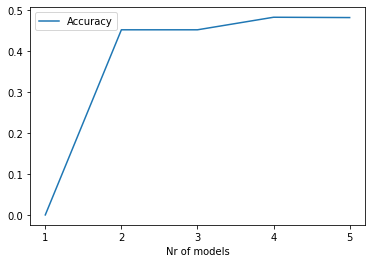

In [53]:
import matplotlib.pyplot as plt

accuracy_df.plot(x="Nr of models", y="Accuracy", xticks=accuracy_df["Nr of models"])
plt.show()

## Correlation between models

In [54]:
predictions = []

for m in tqdm(models):
    predictions.append(np.argmax(m.predict(x_test), axis=1))

100%|██████████| 4/4 [00:01<00:00,  2.08it/s]


In [55]:
correlation_matrix = []

for ix, x in enumerate(predictions):
  row = []
  
  for iy, y in enumerate(predictions):
    if (ix == iy):
      row.append(np.nan)
    else:
      row.append(pearsonr(x,y)[0])

  correlation_matrix.append(row)

correlation_matrix = np.array(correlation_matrix)
display(pd.DataFrame(correlation_matrix))
print("Average correlation: " + str(np.nanmean(correlation_matrix.flatten())))

,0,1,2,3
0,NaN,0.553148,0.608246,0.631323
1,0.553148,NaN,0.622944,0.668767
2,0.608246,0.622944,NaN,0.662058
3,0.631323,0.668767,0.662058,NaN


Average correlation: 0.6244143712317278
